In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

**Importing Datasets**

In [2]:
#To convert the images to Tensor and Normalise between [0,1]
transform = transforms.Compose([
transforms.ToTensor()
]
        )

#Importing MNIST dataset using inbuilt function
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                    shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128,
                                    shuffle=False, num_workers=2, drop_last=True)


**Hyper Parameters**

In [3]:
#Initialising a few Hyper parameters
device = 'cuda'
zd = 64
num_classes = 10
lr = 0.0002
num_epochs = 100
batch_size = 128

**Condiotional GANs Model**

In [4]:

#Defining Generator model using given architecture in Question
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self). __init__()
        self.convT_layers = nn.Sequential(
              nn.ConvTranspose2d(74, 64, kernel_size=3, stride=2, padding=0),
              nn.BatchNorm2d(64),
              nn.Tanh(),
              nn.ConvTranspose2d(64, 128, kernel_size=4, stride=1, padding=0),
              nn.BatchNorm2d(128),
              nn.Tanh(),
              nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),
              nn.BatchNorm2d(64),
              nn.Tanh(),
              nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=0),
              nn.BatchNorm2d(1),
              nn.ReLU()


        )
    def forward(self, z):
        x = self.convT_layers(z)
        return x
    
#Defining Generator model weights using given architecture in Question
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.zero_()
#Defining Discriminator model using given architecture in Question
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(11, 64, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm2d(128), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        out = x.view(x.size(0), -1)
        return out
    
 #Defining Discriminator model weights using given architecture in Question   
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.zero_()



**Training the Model**

In [5]:
#Creating a dictionary to store relavent plots and values
log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'Fake_Images': [],
                'Real_Images': []}


#initialising Discriminator and Generator and their weights
D = Discriminator().to(device)
D.init_weights()

G = Generator().to(device)
G.init_weights()

#initialising Optimizer for Discriminator and Generator
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


#Set Both Models to .train() mode
D.train()
G.train()

#Loss criterion
criterion = nn.BCEWithLogitsLoss()

#Training looop for the model
for epoch in range(num_epochs):
    for batch_idx, (real_images, labels) in enumerate(train_loader):

        #Defining real labels are ones and fake labels are zeros so that the discriminator is able
        #to learn and identify real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        real_images = real_images.to(device)
        labels = labels.to(device)
        #Defining labels for Generator loss.
        flipped_fake_labels = real_labels

        #UPDATING ONLY DISCRIMINATOR
        optimizer_D.zero_grad()

        z = torch.randn(batch_size, zd).to(device)

        #Creation of Cv for concatinating with Zd as per question
        class_labels = torch.zeros(batch_size, num_classes).to(device)
        class_label_onehot = class_labels.scatter_(1, labels.view(batch_size, 1), 1)
        G_concat = torch.cat((z, class_label_onehot), dim=1)
        G_concat = G_concat.unsqueeze(2)       
        G_concat = G_concat.unsqueeze(3)

        #Fake Images generated by Generator
        fake_images = G(G_concat)
        fake_images = fake_images.to(device)


        #Creation of Cm for concatinating with real/fake images as per question
        Cm = torch.zeros((batch_size, 10, 28, 28)).to(device)
        for i in range(batch_size):
            n = labels[i].item()
            Cm[i, n, :, :] = 1

        D_real_concat = torch.cat((real_images, Cm), dim = 1)
        D_fake_concat =  torch.cat((fake_images.detach(), Cm), dim = 1)
        real_predictions = D(D_real_concat)
        fake_predictions = D(D_fake_concat)

        #Calculating Discriminator loss on real and fake prediction
        loss_D_real = criterion(real_predictions, real_labels)
        loss_D_fake = criterion(fake_predictions, fake_labels)
        loss_D = loss_D_real + loss_D_fake

        loss_D.backward()
        optimizer_D.step()       
        #FREEZE DISCRIMINATOR

        #UPDATING ONLY GENERATOR
        optimizer_G.zero_grad()

        # Compute the Discriminator's predictions on the fake images
        fake_predictions = D(torch.cat((fake_images, Cm), dim=1))

        # Compute the loss for the Generator where flipped_fake_Labels is basically just torch.ones
        loss_G = criterion(fake_predictions, flipped_fake_labels)

        loss_G.backward()
        optimizer_G.step()

    log_dict['train_generator_loss_per_batch'].append(loss_G.item())
    log_dict['train_discriminator_loss_per_batch'].append(loss_D.item())
    if epoch == 0 or epoch == 99:
        log_dict['Fake_Images'].append(
            torchvision.utils.make_grid(fake_images, padding=2, normalize=True))
        log_dict['Real_Images'].append(
            torchvision.utils.make_grid(real_images, padding=2, normalize=True))
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

torch.save({
'model_state_dict': G.state_dict(),
'train_loader': train_loader,
'test_loader': test_loader,
'log_dict' : log_dict,
}, 'Generator_Model.pt')
print('Model Saved')

Epoch [1/100] Loss D: 1.4174, Loss G: 0.4981
Epoch [2/100] Loss D: 1.4394, Loss G: 0.5067
Epoch [3/100] Loss D: 1.4369, Loss G: 0.5138
Epoch [4/100] Loss D: 1.4335, Loss G: 0.5223
Epoch [5/100] Loss D: 1.4228, Loss G: 0.5291
Epoch [6/100] Loss D: 1.4056, Loss G: 0.5380
Epoch [7/100] Loss D: 1.4044, Loss G: 0.5443
Epoch [8/100] Loss D: 1.4007, Loss G: 0.5459
Epoch [9/100] Loss D: 1.4112, Loss G: 0.5602
Epoch [10/100] Loss D: 1.3945, Loss G: 0.5601
Epoch [11/100] Loss D: 1.4012, Loss G: 0.5660
Epoch [12/100] Loss D: 1.4061, Loss G: 0.5616
Epoch [13/100] Loss D: 1.3931, Loss G: 0.5732
Epoch [14/100] Loss D: 1.4133, Loss G: 0.5758
Epoch [15/100] Loss D: 1.3959, Loss G: 0.5891
Epoch [16/100] Loss D: 1.4003, Loss G: 0.5980
Epoch [17/100] Loss D: 1.3855, Loss G: 0.5979
Epoch [18/100] Loss D: 1.3944, Loss G: 0.6015
Epoch [19/100] Loss D: 1.3959, Loss G: 0.6005
Epoch [20/100] Loss D: 1.4025, Loss G: 0.6110
Epoch [21/100] Loss D: 1.4089, Loss G: 0.5641
Epoch [22/100] Loss D: 1.4055, Loss G: 0.57

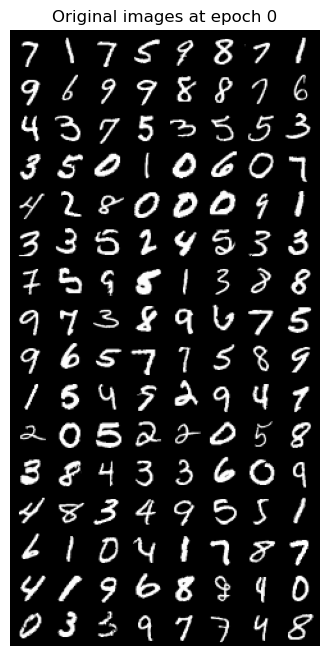

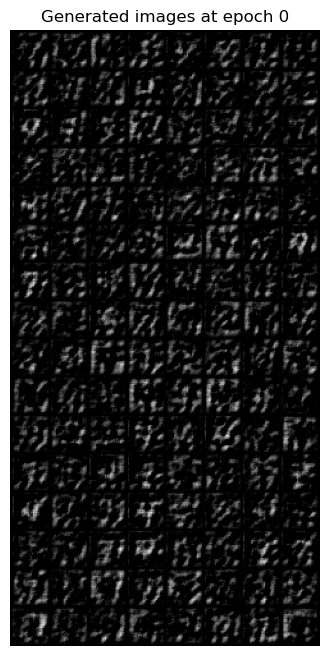

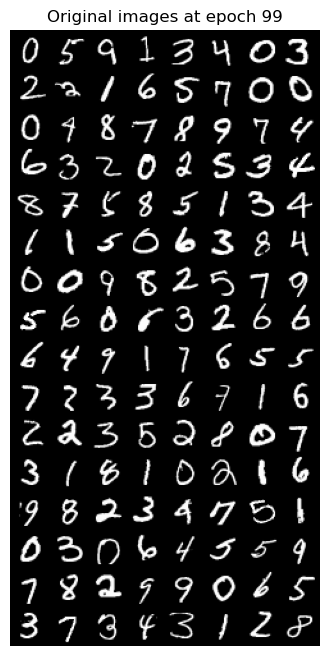

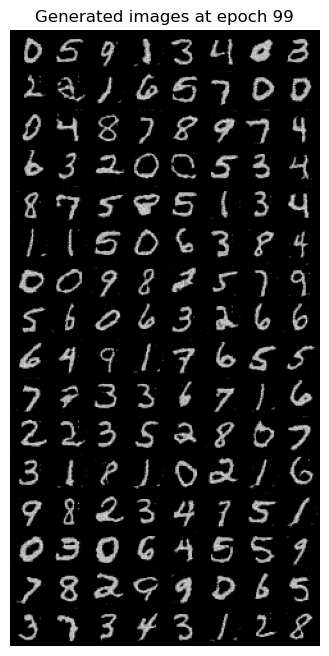

In [7]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Original images at epoch {0}')
img = log_dict['Real_Images'][0].cpu().numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images at epoch {0}')
img = log_dict['Fake_Images'][0].cpu().numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Original images at epoch {99}')
img = log_dict['Real_Images'][1].cpu().numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images at epoch {99}')
img = log_dict['Fake_Images'][1].cpu().numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()


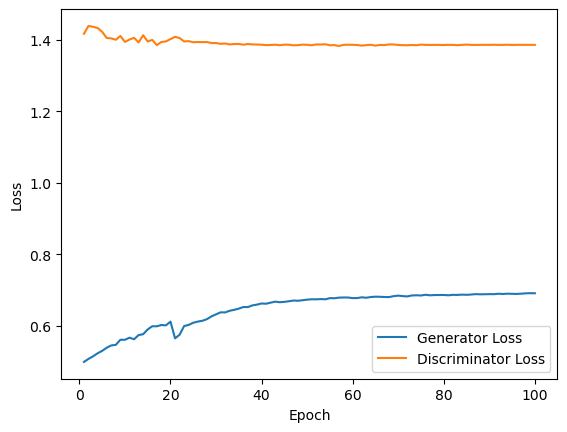

In [8]:
# Get the generator and discriminator losses from the log_dict
gen_losses = log_dict['train_generator_loss_per_batch']
disc_losses = log_dict['train_discriminator_loss_per_batch']

# Create a list of epoch numbers
epochs = list(range(1, len(gen_losses) + 1))

# Plot the losses
plt.plot(epochs, gen_losses, label='Generator Loss')
plt.plot(epochs, disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()